In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer

# 读取数据
df = pd.read_csv('traindata.csv')
df['comment'] = df['comment'].astype(str)

# 替换任何缺失的评论（如果存在）
df['comment'] = df['comment'].fillna('')
# 分词器加载
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 标签编码
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# 将数据拆分为训练集和验证集
train_texts, val_texts, train_labels, val_labels = train_test_split(df['comment'], df['label'], test_size=0.2)

# 数据编码
def encode(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

train_encodings = encode(train_texts)
val_encodings = encode(val_texts)


In [2]:
from transformers import BertModel
import torch.nn as nn


class BERT_Transformer_Model(nn.Module):
    def __init__(self, transformer_hidden_dim=128, num_classes=6):
        super(BERT_Transformer_Model, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        
        # 冻结 BERT 的所有参数
        for param in self.bert.parameters():
            param.requires_grad = False

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=768, nhead=8),
            num_layers=6
        )
        self.fc = nn.Linear(768, num_classes)
        
    def forward(self, input_ids, attention_mask):
        # 获取 BERT 的输出
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state
        
        # Transformer处理
        transformer_out = self.transformer(sequence_output)
        
        # 取Transformer最后一个时间步的输出
        transformer_out = transformer_out[:, -1, :]
        
        # 全连接层输出
        logits = self.fc(transformer_out)
        return logits

model=BERT_Transformer_Model()

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import torch.nn.functional as F

# 构建训练数据和验证数据
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels.values))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels.values))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# 定义优化器和损失函数
optimizer = AdamW(model.fc.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# 训练循环
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10


Epoch 1, Training loss: 1.5199, Training accuracy: 0.4371
Validation loss: 1.4422, Validation accuracy: 0.4577
Epoch 2, Training loss: 1.4048, Training accuracy: 0.5029
Validation loss: 1.3321, Validation accuracy: 0.5470
Epoch 3, Training loss: 1.3357, Training accuracy: 0.5272
Validation loss: 1.2709, Validation accuracy: 0.5589
Epoch 4, Training loss: 1.2881, Training accuracy: 0.5434
Validation loss: 1.2346, Validation accuracy: 0.5475
Epoch 5, Training loss: 1.2554, Training accuracy: 0.5527
Validation loss: 1.1964, Validation accuracy: 0.5708
Epoch 6, Training loss: 1.2334, Training accuracy: 0.5559
Validation loss: 1.1781, Validation accuracy: 0.5645
Epoch 7, Training loss: 1.2141, Training accuracy: 0.5629
Validation loss: 1.1511, Validation accuracy: 0.5929
Epoch 8, Training loss: 1.1990, Training accuracy: 0.5673
Validation loss: 1.1332, Validation accuracy: 0.6106
Epoch 9, Training loss: 1.1819, Training accuracy: 0.5725
Validation loss: 1.1170, Validation accuracy: 0.6066
E

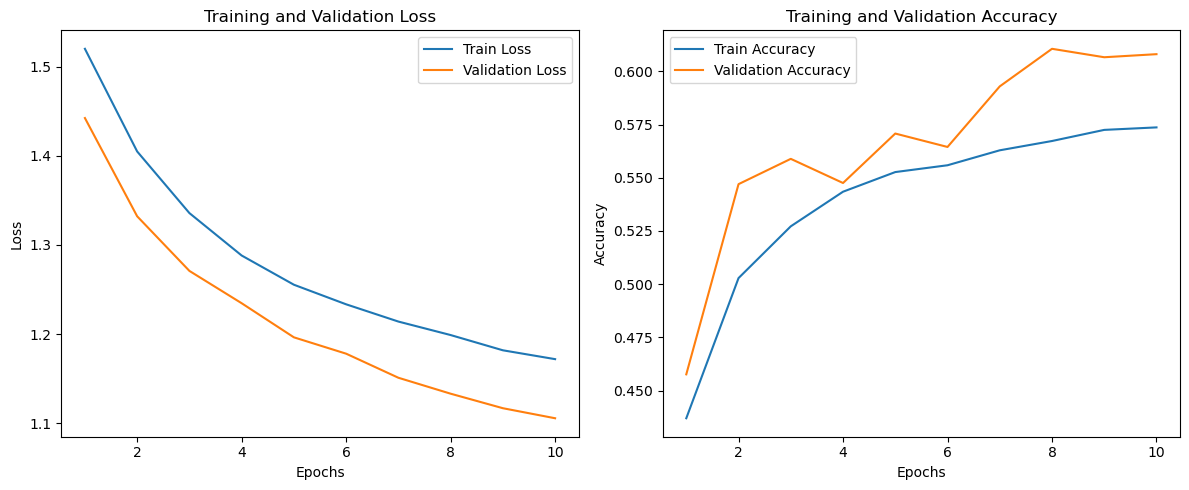

In [6]:
import matplotlib.pyplot as plt
import torch

# 假设有以下初始化：
# model, optimizer, criterion, train_dataloader, val_dataloader, device, epochs

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        
        # Calculate loss
        loss = criterion(logits, labels)
        total_loss += loss.item()
        
        # Calculate training accuracy
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Backward pass
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask)

            # Calculate validation loss
            loss = criterion(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

# 绘制训练过程中的损失和准确率
plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
test_df=pd.read_csv('testdata_with_predictions2.csv')
test_df['content'] = test_df['content'].astype(str)
test_df['content'] = test_df['content'].fillna('')

# 数据编码
test_encodings = encode(test_df['content'])
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [8]:
# 将模型设置为评估模式
model.eval()

predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask = [b.to(device) for b in batch]
        
        # 获取模型的输出
        logits = model(input_ids, attention_mask)
        
        # 获取预测标签
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# 解码预测的标签回原始标签
test_df['freeze_label'] = label_encoder.inverse_transform(predictions)

# 保存结果到文件
test_df.to_csv('testdata_with_predictions3.csv', index=False)

In [9]:
test_df

,文件夹,文件名,content,nofreeze_label,half_freeze_label,freeze_label
0,1029,15.txt,激动,1,1,0
1,1029,15.txt,#从神五到神十九#,0,0,0
2,1029,15.txt,#神十九出征仪式#,1,0,0
3,1029,15.txt,#中国空间站我们90后来了#,1,1,1
4,1029,15.txt,#神十九航天员的出征仪式好可爱#,1,1,1
...,...,...,...,...,...,...
36014,1109,30.txt,[好运连连],1,1,0
36015,1109,30.txt,这次又是什么原因……怎么感觉它三天两头崩一次,4,4,2
36016,1109,30.txt,谁给我指个路、、又谁在被保护,2,2,2
36017,1109,30.txt,怎么又崩了？干啥了,2,3,2
